<a href="https://colab.research.google.com/github/Oxshadha/Bio-Fusion/blob/main/DenseNet121_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Shared utilities for multi-model training in Google Colab
Avoids code duplication across different model experiments
"""

import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, matthews_corrcoef
)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# CONFIGURATION
# ============================================================================

# Dataset path for Google Colab
DATASET_PATH = "/content/GCHTID/HMU-GC-HE-30K/all_image"

# Classes
CLASSES = ['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

# Training hyperparameters
RANDOM_SEED = 42
BATCH_SIZE = 32
NUM_EPOCHS_PHASE1 = 10
NUM_EPOCHS_PHASE2 = 10
EARLY_STOP_PATIENCE = 5

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# ============================================================================
# REPRODUCIBILITY
# ============================================================================

def set_seeds(seed=RANDOM_SEED):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# ============================================================================
# DEVICE SETUP
# ============================================================================

def get_device():
    """Get the best available device (CUDA > CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✓ Using CUDA: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠ Using CPU")
    return device

# ============================================================================
# DATASET LOADING
# ============================================================================

def load_dataset_paths(dataset_root=DATASET_PATH):
    """Load all image paths and labels"""
    image_paths = []
    labels = []

    for class_name in CLASSES:
        class_dir = os.path.join(dataset_root, class_name)
        if os.path.exists(class_dir):
            class_files = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            for filename in class_files:
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(CLASS_TO_IDX[class_name])

    print(f"Loaded {len(image_paths)} images from {len(CLASSES)} classes")
    return image_paths, labels

def create_splits(image_paths, labels, test_size=0.15, val_size=0.15, seed=RANDOM_SEED):
    """Create stratified train/val/test splits"""
    # First split: train vs (val+test)
    X_temp, X_test, y_temp, y_test = train_test_split(
        image_paths, labels, test_size=test_size,
        random_state=seed, stratify=labels
    )

    # Second split: val vs test
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size/(1-test_size),
        random_state=seed, stratify=y_temp
    )

    print(f"Train: {len(X_train)} ({len(X_train)/len(image_paths)*100:.1f}%)")
    print(f"Val: {len(X_val)} ({len(X_val)/len(image_paths)*100:.1f}%)")
    print(f"Test: {len(X_test)} ({len(X_test)/len(image_paths)*100:.1f}%)")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# ============================================================================
# DATASET CLASS
# ============================================================================

class HistopathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# ============================================================================
# TRANSFORMS
# ============================================================================

def get_transforms(augment=True):
    """Get data transforms (with or without augmentation)"""
    if augment:
        # Training: light augmentation
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            # Reduced rotation: ±15° instead of ±90°
            transforms.RandomRotation(degrees=15),
            # Removed color jitter (too aggressive)
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    else:
        # Validation/Test: only normalization
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ])
    return transform

# ============================================================================
# DATA LOADERS
# ============================================================================

def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test,
                       batch_size=BATCH_SIZE, num_workers=2):
    """Create train/val/test dataloaders"""
    train_transform = get_transforms(augment=True)
    val_test_transform = get_transforms(augment=False)

    train_dataset = HistopathologyDataset(X_train, y_train, transform=train_transform)
    val_dataset = HistopathologyDataset(X_val, y_val, transform=val_test_transform)
    test_dataset = HistopathologyDataset(X_test, y_test, transform=val_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================

def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    test_loss, test_acc, test_preds, test_labels = validate(
        model, test_loader, criterion, device
    )

    # Classification report
    class_names = [IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]
    report = classification_report(
        test_labels, test_preds,
        target_names=class_names,
        digits=4,
        output_dict=True
    )

    # Overall metrics
    macro_f1 = f1_score(test_labels, test_preds, average='macro')
    weighted_f1 = f1_score(test_labels, test_preds, average='weighted')
    mcc = matthews_corrcoef(test_labels, test_preds)

    # Per-class F1
    per_class_f1 = f1_score(test_labels, test_preds, average=None)

    results = {
        'test_loss': test_loss,
        'test_acc': test_acc,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'mcc': mcc,
        'per_class_f1': per_class_f1,
        'predictions': test_preds,
        'labels': test_labels,
        'classification_report': report
    }

    return results

def plot_confusion_matrix(y_true, y_pred, model_name, save_path=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    class_names = [IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)',
                     fontsize=14, fontweight='bold')

    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Normalized'})
    axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)',
                     fontsize=14, fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_per_class_f1(per_class_f1_dict, save_path=None):
    """Plot per-class F1 scores for all models"""
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(CLASSES))
    width = 0.2
    offset = 0

    for model_name, f1_scores in per_class_f1_dict.items():
        ax.bar(x + offset, f1_scores, width, label=model_name)
        offset += width

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class F1 Scores Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * (len(per_class_f1_dict) - 1) / 2)
    ax.set_xticklabels(CLASSES)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# EMBEDDING VISUALIZATION
# ============================================================================

def extract_features(model, test_loader, device, num_samples=500):
    """Extract features from penultimate layer"""
    model.eval()
    features_list = []
    labels_list = []

    # Hook to extract features
    def get_features_hook(module, input, output):
        features_list.append(output.view(output.size(0), -1).cpu().numpy())

    # Register hook (assumes model has backbone.avgpool)
    if hasattr(model, 'backbone') and hasattr(model.backbone, 'avgpool'):
        hook = model.backbone.avgpool.register_forward_hook(get_features_hook)
    elif hasattr(model, 'avgpool'):
        hook = model.avgpool.register_forward_hook(get_features_hook)
    else:
        print("Warning: Could not find avgpool layer for feature extraction")
        return None, None

    count = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if count >= num_samples:
                break
            images = images.to(device)
            _ = model(images)
            labels_list.extend(labels.numpy())
            count += len(labels)

    hook.remove()

    if features_list:
        features_array = np.vstack(features_list)
        labels_array = np.array(labels_list[:len(features_array)])
        return features_array, labels_array
    return None, None

def plot_tsne(features, labels, model_name, save_path=None):
    """Plot t-SNE visualization"""
    from sklearn.manifold import TSNE

    print(f"Computing t-SNE for {model_name}...")
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 10))
    for class_idx in range(NUM_CLASSES):
        mask = labels == class_idx
        if np.sum(mask) > 0:
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                       label=IDX_TO_CLASS[class_idx], alpha=0.6, s=50)

    plt.xlabel('t-SNE Dimension 1', fontsize=12, fontweight='bold')
    plt.ylabel('t-SNE Dimension 2', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} - t-SNE Visualization', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# MODEL COMPARISON
# ============================================================================

def compare_models(results_dict, save_path=None):
    """Compare multiple models' performance"""
    models = list(results_dict.keys())
    metrics = ['test_acc', 'macro_f1', 'weighted_f1', 'mcc']

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        values = [results_dict[model][metric] for model in models]
        axes[idx].bar(models, values, color='steelblue', edgecolor='black')
        axes[idx].set_ylabel(metric.replace('_', ' ').title(),
                             fontsize=12, fontweight='bold')
        axes[idx].set_title(f'{metric.replace("_", " ").title()} Comparison',
                           fontsize=12, fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels
        for i, v in enumerate(values):
            axes[idx].text(i, v + 0.01, f'{v:.4f}',
                          ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary table
    print("\n" + "="*80)
    print("MODEL COMPARISON SUMMARY")
    print("="*80)
    print(f"{'Model':<20} {'Accuracy':<12} {'Macro F1':<12} {'Weighted F1':<12} {'MCC':<12}")
    print("-"*80)
    for model in models:
        r = results_dict[model]
        print(f"{model:<20} {r['test_acc']:<12.4f} {r['macro_f1']:<12.4f} "
              f"{r['weighted_f1']:<12.4f} {r['mcc']:<12.4f}")
    print("="*80)



Streaming output truncated to the last 5000 lines.
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_350.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3500.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3501.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3502.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3503.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3504.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3505.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3506.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3507.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3508.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3509.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_351.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3510.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3511.png  
  inflating: GCHTID/HMU-GC-HE-30K/all_image/STR/STR_3512.png  
  infl

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 181MB/s]


PHASE 1: Training Classifier Head
Epoch [1/10]
  Train: Loss=1.5721, Acc=46.44%
  Val: Loss=1.3220, Acc=58.35%
  ✓ Best model saved
Epoch [2/10]
  Train: Loss=1.4988, Acc=50.73%
  Val: Loss=1.2989, Acc=60.39%
  ✓ Best model saved
Epoch [3/10]
  Train: Loss=1.4826, Acc=51.31%
  Val: Loss=1.2982, Acc=59.49%
  ✓ Best model saved
Epoch [4/10]
  Train: Loss=1.4953, Acc=50.79%
  Val: Loss=1.3115, Acc=59.31%
Epoch [5/10]
  Train: Loss=1.4935, Acc=50.89%
  Val: Loss=1.3372, Acc=56.66%
Epoch [6/10]
  Train: Loss=1.4854, Acc=50.94%
  Val: Loss=1.3220, Acc=58.41%
Epoch [7/10]
  Train: Loss=1.4804, Acc=51.71%
  Val: Loss=1.3019, Acc=59.21%
Epoch [8/10]
  Train: Loss=1.4821, Acc=50.92%
  Val: Loss=1.3026, Acc=58.93%

PHASE 2: Fine-tuning
Epoch [1/10]
  Train: Loss=1.4524, Acc=52.26%
  Val: Loss=1.2945, Acc=59.74%
  ✓ Best model saved
Epoch [2/10]
  Train: Loss=1.4474, Acc=53.01%
  Val: Loss=1.2921, Acc=59.42%
  ✓ Best model saved
Epoch [3/10]
  Train: Loss=1.4409, Acc=52.97%
  Val: Loss=1.2919, Acc

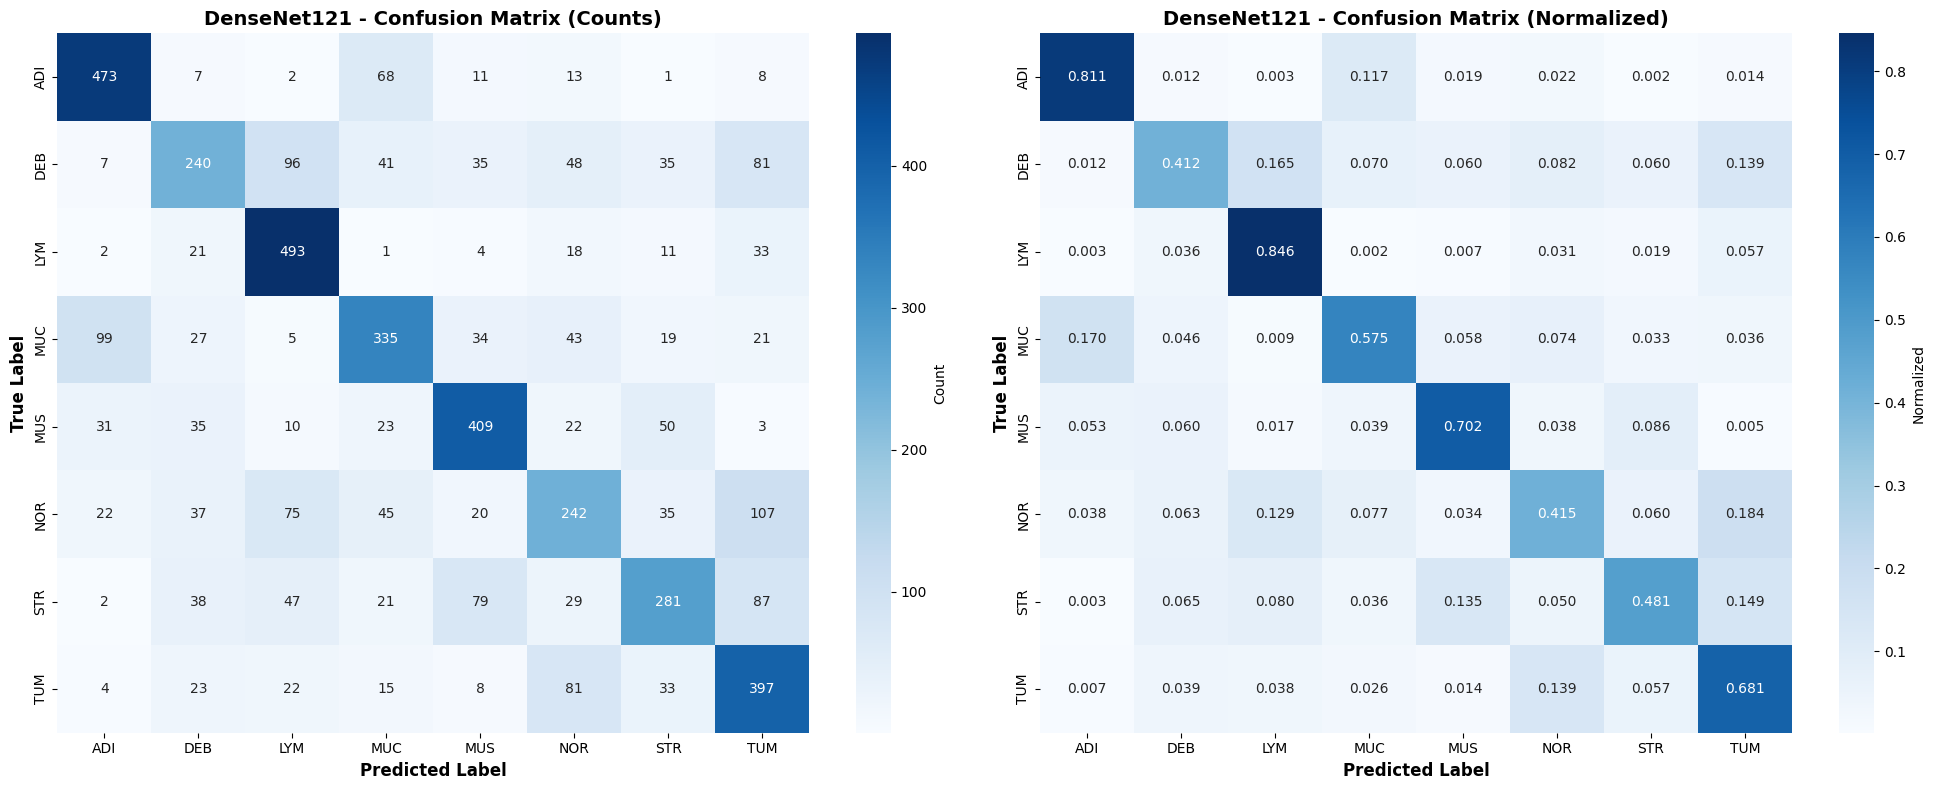

In [ ]:
"""
DenseNet121 Model Training
Run this in Google Colab Account 3
"""

# Setup dataset
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d orvile/gastric-cancer-histopathology-tissue-image-dataset
!unzip gastric-cancer-histopathology-tissue-image-dataset.zip -d GCHTID

import sys
sys.path.append('/content')


import torch.nn as nn
import torch.optim as optim
from torchvision import models

# ============================================================================
# MODEL DEFINITION
# ============================================================================

class DenseNet121Classifier(nn.Module):
    def __init__(self, num_classes=8, dropout=0.5):
        super().__init__()
        self.backbone = models.densenet121(pretrained=True)
        num_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True

    def unfreeze_top_layers(self, num_layers=2):
        for param in self.backbone.classifier.parameters():
            param.requires_grad = True
        # Unfreeze last dense blocks
        dense_blocks = [m for m in self.backbone.features if 'denseblock' in str(type(m))]
        for block in dense_blocks[-num_layers:]:
            for param in block.parameters():
                param.requires_grad = True

# ============================================================================
# TRAINING (Same structure)
# ============================================================================

def train_model():
    set_seeds()
    device = get_device()

    image_paths, labels = load_dataset_paths()
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = create_splits(
        image_paths, labels
    )
    train_loader, val_loader, test_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test
    )

    model = DenseNet121Classifier(num_classes=NUM_CLASSES, dropout=0.5).to(device)
    model.freeze_backbone()

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Phase 1
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3, weight_decay=1e-4
    )

    print("="*60)
    print("PHASE 1: Training Classifier Head")
    print("="*60)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(NUM_EPOCHS_PHASE1):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE1}]")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'densenet_phase1_best.pt')
            print(f"  ✓ Best model saved")
        else:
            patience_counter += 1
            if patience_counter >= EARLY_STOP_PATIENCE:
                break

    # Phase 2
    model.load_state_dict(torch.load('densenet_phase1_best.pt'))
    model.unfreeze_top_layers(num_layers=2)

    backbone_params = []
    head_params = []
    for name, param in model.named_parameters():
        if 'classifier' in name:
            head_params.append(param)
        elif param.requires_grad:
            backbone_params.append(param)

    optimizer_phase2 = optim.AdamW([
        {'params': head_params, 'lr': 1e-4},
        {'params': backbone_params, 'lr': 1e-4}
    ], weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_phase2, mode='min', factor=0.5, patience=3
    )

    print("\n" + "="*60)
    print("PHASE 2: Fine-tuning")
    print("="*60)

    best_val_loss_phase2 = float('inf')
    patience_counter_phase2 = 0

    for epoch in range(NUM_EPOCHS_PHASE2):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer_phase2, device
        )
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS_PHASE2}]")
        print(f"  Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"  Val: Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

        if val_loss < best_val_loss_phase2:
            best_val_loss_phase2 = val_loss
            patience_counter_phase2 = 0
            torch.save(model.state_dict(), 'densenet_final.pt')
            print(f"  ✓ Best model saved")
        else:
            patience_counter_phase2 += 1
            if patience_counter_phase2 >= EARLY_STOP_PATIENCE:
                break

    # Evaluation
    model.load_state_dict(torch.load('densenet_final.pt'))
    results = evaluate_model(model, test_loader, criterion, device)

    print("\n" + "="*60)
    print("DENSENET121 FINAL RESULTS")
    print("="*60)
    print(f"Test Accuracy: {results['test_acc']:.2f}%")
    print(f"Macro F1: {results['macro_f1']:.4f}")

    plot_confusion_matrix(
        results['labels'], results['predictions'],
        'DenseNet121', save_path='densenet_cm.png'
    )

    import json
    with open('densenet_results.json', 'w') as f:
        json.dump({
            'test_acc': float(results['test_acc']),
            'macro_f1': float(results['macro_f1']),
            'weighted_f1': float(results['weighted_f1']),
            'mcc': float(results['mcc']),
            'per_class_f1': results['per_class_f1'].tolist()
        }, f, indent=2)

    return model, results, history

if __name__ == '__main__':
    model, results, history = train_model()

